# Dask DataFrame Experiment

## Part 3

Use Dask to convert a pandas dataframe into a text file in 'fixed position' format, with custom encoding.

## Imports

In [1]:
import os
import time
import pickle
import pandas as pd

from collections import OrderedDict
from pprint import PrettyPrinter

from dask.distributed import Client
import dask.dataframe as dd

pp = PrettyPrinter(indent=4).pprint
# %config IPCompleter.greedy=True

## Custom data encoding helper

In [2]:
class EBCDIC:
    
    def __init__(self, logger, cp='cp037'):
        self.logger = logger
        self.cp = cp
        self.cp_blank = ' '.encode(cp)
    
    def _log_error_msg1(msg: str):
        self.logger(f"ERROR: Function ::{msg}:: Returned error.")
        
    def _log_error_msg2(msg: tuple):
        self.logger(f"ERROR: Function ::{msg[0]}:: {msg[1]}.")
    
    def to_char(self, string, size) -> bytes:
        try:
            s = string.encode(self.cp)[:size]
            if len(s) < size:
                s += self.cp_blank * (size - len(s))
            return s
        except:
            self._log_error_msg1('to_char()')

    def to_pib(self, integer: int, size: int) -> bytes:
        if size not in [1, 2, 4, 8]:
            self._log_error_msg2(('to_pib()', "'size' must be one of: 1, 2, 4, or 8."))
            return None
        
        try:
            h = hex(integer)[2:]
            if len(h) % 2 == 1:
                h = '0' + h
                
            s = int(len(h) / 2)
            if s > size:
                self._log_error_msg2(('to_pib()', "'size' not large enough for the 'integer'."))
                return None
            elif s < size:
                h = '0' * ((size - s) * 2) + h
            
            return bytes.fromhex(h)
        except:
            self._log_error_msg1('to_pib()')
            return None
        
    # Truncated for brevity
    
E = EBCDIC(print)

## Functions

In [3]:
# This will speed up access to the data during multiple calls
records_d = OrderedDict()

# Convert a single 'cell' value with the given conversion type
def convert_to_ebcdic(value, size, conv, pre):
    
    pre_b = b''
    
    if pre != '':
        pre_b = E.to_char(pre, len(pre))

    if conv == 'CHAR':
        if type(value) != str:
            value = str(value)
        return pre_b + E.to_char(value, size)
    
    # Truncated 
    
# Map an entire record (row) to a bytes array
def map_rec_to_bytes(rec: pd.Series):
    
    # Get the record layout dict for this record
    record_d = records_d[rec['rec_lbl']]
    
    # Start the binary record
    b_rec = b''
    
    # Mark the current position in the fixed position record
    pos = 1
    
    # Loop through all fields in the layout
    for field in record_d.keys():
        start = record_d[field]['start']
        length = record_d[field]['length']
        conversion = record_d[field]['conversion']
        
        if pos < start:
            prepend = ' ' * (start-pos)
        else:
            prepend = ''
        
        pos = start + length
        
        b_rec += convert_to_ebcdic(rec[field], length, conversion, prepend)
    
    # Add 4 positions for the IBM RDW - minus 1 because pos tracks the position of the next value
    rec_len = pos + 4 - 1
    
    # The IBM RDW is made up of 2 parts
    ibm_rdw = E.to_pib(rec_len, 2) + E.to_pib(0, 2)
    
    return ibm_rdw + b_rec

# Map an entire pandas dataframe with the function
def map_pandas_df(df: pd.DataFrame) -> pd.DataFrame:
    s = df.apply(
        map_rec_to_bytes,
        axis=1
    )
    
    max_length = s.str.len().max()
    
    return pd.DataFrame(
        [[
            b''.join(s.tolist()), max_length
        ]],
        columns=['Binary Data', 'Rec Length']
    )

## Convert the data using Dask

In [4]:
# Data location
DATA = 'data'

def dask_convert_data(count=5000, nworkers=1, multiple=1):
    file_path_data = os.path.join(os.getcwd(), DATA, str(count)+'_data.pickle')
    file_path_layout = os.path.join(os.getcwd(), DATA, str(count)+'_layout.pickle')
    file_path_records = os.path.join(os.getcwd(), DATA, str(count)+'_records.pickle')

    with open(file_path_data, 'rb') as f:
        data_df = pickle.load(f)
    with open(file_path_layout, 'rb') as f:
        layout_df = pickle.load(f)
    with open(file_path_records, 'rb') as f:
        records_df = pickle.load(f)
        
    print(data_df.shape)
    multiple -= 1
    if multiple > 0:
        data_df = data_df.append([data_df]*multiple,ignore_index=True)
    print(data_df.shape)
    
    # Convert the layout dataframe to dict
    # Iterate over each unique record 
    for record in layout_df['rec'].unique():
        fields_d = OrderedDict()
        # Iterate over each unique field 'name' in the record
        for field in layout_df[layout_df['rec']==record]['name'].unique():
            fields_d[field] = layout_df[
                (layout_df['rec'] == record) & (layout_df['name'] == field)
            ][['start', 'length', 'conversion']].to_dict('records')[0]
        records_d[record] = fields_d
    
    # Add record label to data dataframe
    records_l = records_df.values.tolist()
    
    data_df['rec_lbl'] = ''
    
    for rec in records_l:
        data_df.loc[eval(rec[1]), ['rec_lbl']] = rec[0]
        
    parts = nworkers*2
    
    # Start measuring time
    dask_start = time.time()
    
    # Set up Dask client
    client = Client(n_workers=nworkers, threads_per_worker=2)

    print(f"Client using processes: {client.cluster.processes}")
    pp(client.cluster.workers)
    
    ddf = dd.from_pandas(data_df, npartitions=parts)

    # Map the data
    result = ddf.map_partitions(
        map_pandas_df,
        meta={
            'Binary Data': 'object',
            'Rec Length': 'int64'
        }
    ).compute()

    dask_result = pd.DataFrame(
        [[
            b''.join(list(result['Binary Data'].values)), result['Rec Length'].max()
        ]],
        columns=['Binary Data', 'Rec Length']
    )
    
    dask_secs = time.time() - dask_start
    print(f"Total time: {dask_secs:.3f} seconds")
    
    return dask_result

In [5]:
%%time
df = dask_convert_data(count=5000, nworkers=4, multiple=1)
# df = dask_convert_data(count=50000, nworkers=4, multiple=2)
# df = dask_convert_data(count=500000, nworkers=4, multiple=1)
# df = dask_convert_data(count=5000000, nworkers=4)

print(df.shape)
df.head()

(34943, 12)
(34943, 12)
Client using processes: True
{   0: <Nanny: tcp://127.0.0.1:59106, threads: 2>,
    1: <Nanny: tcp://127.0.0.1:59097, threads: 2>,
    2: <Nanny: tcp://127.0.0.1:59103, threads: 2>,
    3: <Nanny: tcp://127.0.0.1:59100, threads: 2>}
Total time: 3.789 seconds
(1, 2)
Wall time: 3.92 s


,Binary Data,Rec Length
0,b'\x00^\x00\x00\xd7\xd9\xe2\xd5@@@@@@\xf5\xf8\...,179


### Dask performance

#### 1 worker
Using i7-7700HQ @ 3.54-3.60 GHz

- for ~35,000 records --> 5.50 secs (159% pandas)
- for ~350,000 records --> 41.26 secs (117% pandas)
- for ~3,500,000 records --> 6 mins 41 secs (101% pandas)
- for ~35,000,000 records --> Not Measured (likely MemoryError)
   - See Pandas performance for how long this took
   - Spoiler (or not) ... it was a long time! :)

Notes - Some single threaded loads initially. Then upto 27% load. Memory usage up from 8GB to 11GB.

#### 2 workers
Using i7-7700HQ @ 3.46-3.55 GHz

- for ~35,000 records --> 4.4 secs (128% pandas)
- for ~350,000 records --> 26.02 secs (74% of pandas)
- for ~3,500,000 records --> 4 mins 11.79 secs (64% pandas)
- for ~35,000,000 records --> Not Measured (likely MemoryError)

Notes - Some single threaded loads initially. Then upto 44% load. Memory usage up from 8GB to 11GB.

#### 3 workers
Using i7-7700HQ @ 3.41-3.47 GHz

- for ~35,000 records --> 3.81 secs (110% pandas)
- for ~350,000 records --> 18.52 secs (52% of pandas)
- for ~3,500,000 records --> 2 mins 38.70 secs (40% pandas)
- for ~35,000,000 records --> Not Measured (likely MemoryError)

Notes - Some single threaded loads initially. Then upto 62% load. Memory usage up from 8GB to 11GB.

#### 4 workers
Using i7-7700HQ @ 3.40-3.45 GHz

- for ~35,000 records --> 3.65 secs (106% pandas)
- for ~350,000 records --> 16.34 secs (46% pandas)
- for ~3,500,000 records --> 2 mins 19.67 secs (35% pandas)
   - RAM used 8.8 GB
- for ~7,000,000 records --> 4 mins 32.21 secs
   - RAM used 12.4 GB
- for ~10,500,000 records --> 6 mins 46.21 secs
   - RAM used 15.6 GB
- for ~35,000,000 records --> MemoryError
   - RAM limited at 15.9 GB

Notes - Some single threaded loads initially. Then upto 91% load. Memory usage up from 8GB to 11GB.

In [33]:
results_list = [
    ['Pandas', '35,000', 3.45],
    ['Pandas', '350,000', 35.40],
    ['Pandas', '3,500,000', 396.00],
    
    ['Dask 1', '35,000', 5.50],
    ['Dask 1', '350,000', 41.26],
    ['Dask 1', '3,500,000', 401.00],
    
    ['Dask 2', '35,000', 4.40],
    ['Dask 2', '350,000', 26.02],
    ['Dask 2', '3,500,000', 251.79],
    
    ['Dask 3', '35,000', 3.81],
    ['Dask 3', '350,000', 18.52],
    ['Dask 3', '3,500,000', 158.70],
    
    ['Dask 4', '35,000', 3.65],
    ['Dask 4', '350,000', 16.34],
    ['Dask 4', '3,500,000', 139.67],
    ['Dask 4', '7,000,000', 272.21],
    ['Dask 4', '10,500,000', 406.21],
]

In [34]:
import seaborn as sns

In [35]:
df_results = pd.DataFrame(results_list, columns=['Method', 'Records', 'Seconds'])

In [36]:
sns.set(style="whitegrid")

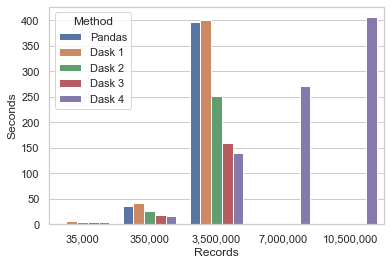

In [50]:
sns_all = sns.barplot(x="Records", y="Seconds", hue="Method", data=df_results)

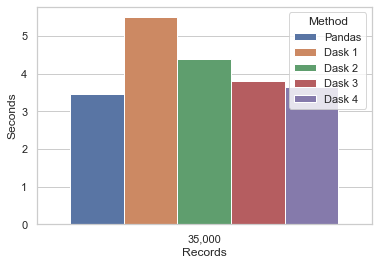

In [51]:
sns_1st = sns.barplot(x="Records", y="Seconds", hue="Method", data=df_results[df_results.Records=='35,000'])

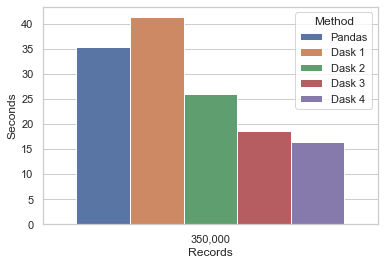

In [52]:
sns_2nd = sns.barplot(x="Records", y="Seconds", hue="Method", data=df_results[df_results.Records=='350,000'])

In [54]:
fig_all = sns_all.get_figure()
fig_1st = sns_1st.get_figure()
fig_2nd = sns_2nd.get_figure()

fig_all.savefig('./imgs/all_Records.png')
fig_1st.savefig('./imgs/1st_Records.png')
fig_2nd.savefig('./imgs/2nd_Records.png')